<a href="https://colab.research.google.com/github/frankausberlin/notebook-collection/blob/main/snippetpearls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table width=1000><tr></tr><tr><td align='center'><font size='+10'><b>
SnippetPearls</b></font></td></tr><tr></tr><tr><td align='center'><p>
This is a jupyter notebook with several and I hope useful<br> code snippets around very interesting technologies.</td></tr><tr></tr><tr><td align='center'>
optimized for google colab</td></tr></table><br><br>

---

ps.

There are problems with the tab-widget from ipywidgets. In some constellations it will not be rendered (local runtime, chrome on windows, maybe more). But it works correctly (it just draw the content one after the other and not in tabs).

you can look [here](https://github.com/googlecolab/colabtools/issues/3105)

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
import gspread
from oauth2client.client import GoogleCredentials
 
gc = gspread.authorize(GoogleCredentials.get_application_default())


In [ ]:
# colab forms
#
#@title       command shell { form-width: "300px" }
#@markdown    * using [jQuery Terminal](https://terminal.jcubic.pl/) - example on [github](https://github.com/alessandrobessi/colab-shell)
#
#
%matplotlib inline
import                            os
from   google.colab       import  widgets, output
from   IPython.display    import  display, HTML, JSON
from   subprocess         import  getoutput

width  = 800 #@param {type: "slider", min: 400, max: 1200, step: 100}
height = 400 #@param {type: "slider", min: 100, max: 800, step: 100}
printHistory = False #@param {type:"boolean"}

# function for invoke-callback-mechanism
def shell(command):
  # print history an reselect command tab
  if printHistory:
    with tabs.output_to('history'): print(command)
    with tabs.output_to('command'): pass

  # catch cd-command 
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])

  # all other commands
  return JSON([getoutput(command)])

# register to invoke
output.register_callback('shell', shell)

# the tabs
tabs = widgets.TabBar(['command','history'])

# create command tab using javascript with 'display(HTML(...'
with tabs.output_to('command'): display(HTML('''
  <div id=term_demo></div>
  <script src="https://code.jquery.com/jquery-latest.js"></script>
  <script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
  <link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
  <script>
    $('#term_demo').terminal(async function(command) {
        if (command !== '') {
            try {
                let res = await google.colab.kernel.invokeFunction('shell', [command])
                let out = res.data['application/json'][0]
                this.echo(new String(out))
            } catch(e) {
                this.error(new String(e));
            }
        } else {
            this.echo('');
        }
    }, {
        greetings: 'Welcome to Colab Shell',
        name: 'colab_shell',
        height: '''+str(height)+''', 
        width: '''+str(width)+''',
        prompt: 'colab > '
    });
  </script>'''))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title image search { form-width: "300px" }
#@markdown This little snippet does a picture search with DuckDuckGo (jpg, png, gif, bmp) and show the results (thumbnails). 
#@markdown * It creates a folder content/images (local runtime: ~/labor/content/images) and there a new folder for every search.
#@markdown * The image thumbnails (and optional the images) will be downloaded in the search folder. 
#@markdown * It will generate a bash script (easy remove bad pictures) for downloading the images later (or again).

import                            time, json, re, ipywidgets, os, \
                                  requests, matplotlib
from matplotlib           import  pyplot as plt
from urllib.parse         import  urlencode, quote, urlparse, urlunparse
from urllib.request       import  build_opener, Request
from urllib.error         import  HTTPError, URLError
from google.colab         import  widgets
from PIL                  import  Image
from tqdm                 import  tqdm

query                     = 'angry cat' #@param {type:"string"}
results                   = 50 #@param {type: "slider", min: 1, max: 999, step: 1}
downloadImages            = False #@param {type:"boolean"}
                            #@markdown **thumbnails display**
columns                   = 5 #@param {type: "slider", min: 1, max: 20, step: 1}
rows                      = 2 #@param {type: "slider", min: 1, max: 100, step: 1}

##########################################################################################################
########################## reversed from https://course.fast.ai/ #########################################
##########################################################################################################
url_default_headers = {
    "Accept":
    "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "Accept-Language": "en-US,en;q=0.9",
    "Cache-Control": "max-age=0",
    "Sec-Fetch-Dest": "document",
    "Sec-Fetch-Mode": "navigate",
    "Sec-Fetch-Site": "none",
    "Sec-Fetch-User": "?1",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"
}

ExceptionsHTTP = {}

def urlquote(url):
    "Update url's path with `urllib.parse.quote`"
    subdelims = "!$&'()*+,;="
    gendelims = ":?#[]@"
    safe = subdelims+gendelims+"%/"
    p = list(urlparse(url))
    p[2] = quote(p[2], safe=safe)
    for i in range(3,6): p[i] = quote(p[i], safe=safe)
    return urlunparse(p)

def loads(s, **kw):
    "Same as `json.loads`, but handles `None`"
    if not s: return {}
    try: import ujson as json
    except ModuleNotFoundError: import json
    return json.loads(s, **kw)

def urlwrap(url, data=None, headers=None):
    "Wrap `url` in a urllib `Request` with `urlquote`"
    return url if isinstance(url,Request) else Request(urlquote(url), data=data, headers=headers or {})

def urlopener():
    _opener = build_opener()
    _opener.addheaders = list(url_default_headers.items())
    return _opener

def urlopen(url, data=None, headers=None, timeout=None, **kwargs):
    "Like `urllib.request.urlopen`, but first `urlwrap` the `url`, and encode `data`"
    if kwargs and not data: data=kwargs
    if data is not None:
        if not isinstance(data, (str,bytes)): data = urlencode(data)
        if not isinstance(data, bytes): data = data.encode('ascii')
    try: return urlopener().open(urlwrap(url, data=data, headers=headers), timeout=timeout)
    except HTTPError as e: 
        e.msg += f"\n====Error Body====\n{e.read().decode(errors='ignore')}"
        raise

def urlread(url, data=None, headers=None, decode=True, return_json=False, return_headers=False, timeout=None, **kwargs):
    "Retrieve `url`, using `data` dict or `kwargs` to `POST` if present"
    try:
        with urlopen(url, data=data, headers=headers, timeout=timeout, **kwargs) as u: res,hdrs = u.read(),u.headers
    except HTTPError as e:
        if 400 <= e.code < 500: raise ExceptionsHTTP[e.code](e.url, e.hdrs, e.fp) from None
        else: raise

    if decode: res = res.decode()
    if return_json: res = loads(res)
    return (res,dict(hdrs)) if return_headers else res

def isddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    xu,data = list(),{'next':1} # little change: don't use the mysterious L class
    headers = dict(referer='https://duckduckgo.com/')
    while len(xu)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            for i in range(len(data['results'])):
              xu.append(data['results'][i])
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return xu[:max_images]
##########################################################################################################
##########################################################################################################
##########################################################################################################

# download the ddg results page (links)
links                 = isddg (query,results)
if downloadImages:    print (f'checking {len(links)} links - start download thumbnails and images')
else:                 print (f'checking {len(links)} links - start download thumbnails')

# mkdir
qfolder       = query.replace (' ','')
if os.path.exists('/content'):
  os.makedirs   ('/content/images',exist_ok=True)
  os.makedirs   (f'/content/images/{qfolder}',exist_ok=True)
  os.chdir      (f'/content/images/{qfolder}')
else:
  os.makedirs   (f'{os.path.expanduser("~")}/labor/content',exist_ok=True)
  os.makedirs   (f'{os.path.expanduser("~")}/labor/content/images',exist_ok=True)
  os.makedirs   (f'{os.path.expanduser("~")}/labor/content/images/{qfolder}',exist_ok=True)
  os.chdir      (f'{os.path.expanduser("~")}/labor/content/images/{qfolder}')


# inits
pos, bad, thumbs, bash = 0, 0, [], f'#!/bin/bash\nmkdir -p {qfolder}\n'

# loop the links
for all in tqdm(links): 

  # extract infos
  url  = all['image']
  turl = all['thumbnail']
  ext  = url.split('.')[-1]
  if '?' in ext: ext = ext.split('?')[0]
  dest = f"{qfolder}{pos-bad}.{ext}"
  pos+=1

  # check extension
  if ext.lower() in 'jpg png gif bmp':

    # download image und thumbnail
    try:

      # image
      if downloadImages:
        im = Image.open(requests.get(url, stream = True).raw)
        im.save(dest)

      # bash script entry
      bash += f'# Picture {dest}\ncurl "{url}" --output {qfolder}/{dest}\n' 

      # thumbnail
      im = Image.open(requests.get(turl, stream = True).raw)
      im.save('thumb'+dest) 
      thumbs.append('thumb'+dest)

    # count bad links
    except Exception:
      bad += 1
  else:
    bad += 1

# output infos
if not downloadImages:  txt = f'downloaded {len(thumbs)} thumbnails'
else:                   txt = f'downloaded {len(thumbs)} images and thumbnails'   
print                   (f'\n\n\x1b[32m{txt}\x1b[0m - \x1b[91mfound {bad} bad links!!!\x1b[0m')

# write bash 
if os.path.exists('/content'):
  print    (f'Create bash script: \x1b[34m/content/images/dl_{qfolder}.sh\x1b[0m')
  open     (f'/content/images/dl_{qfolder}.sh', 'w').write(bash)
else:
  print    (f'Create bash script: \x1b[34m~/labor/content/images/dl_{qfolder}.sh\x1b[0m')
  open     (f'{os.path.expanduser("~")}/labor/content/images/dl_{qfolder}.sh', 'w').write(bash)


# build the thumbnails tabs
titles, len_thumbs = [], len(thumbs)
for i in range(0,len_thumbs,(columns*rows)):
  x = ((i//(columns*rows))+1)*(columns*rows)-1
  if x >= len_thumbs: x = len_thumbs-1
  titles.append(f'{i}-{x}')
tabs = widgets.TabBar(titles)

# title font
matplotlib.rc('font', **{'sans-serif':    'DejaVu Sans',
                          'family':        'sans-serif',
                          'weight':        'bold', 
                          'size':          (columns+10 if columns > 12 else 16) })  

# fill the tabs
for i,t in enumerate(titles):
  with tabs.output_to (t): 
    
    # figure dimension (inch)
    fig = plt.figure(figsize=(4*columns, 4.25*rows))
    
    # all images for the tab i
    for j in range(columns*rows):
      x = i*(columns*rows)+j

      # subplot image
      if x < len_thumbs:
        fig.add_subplot(rows, columns, j+1, xticks=[], yticks=[], title=f'{x}')
        im = Image.open (thumbs[x])
        plt.imshow(im)

# cd to image folder         
if os.path.exists('/content'): os.chdir (f'/content/images')
else: os.chdir (f'{os.path.expanduser("~")}/labor/content/images')


In [ ]:
#@title debug { form-width: "700px" }
#@markdown * When an error happens you can run **%debug** in a new code cell.
#@markdown * Or you set a breakpoint with ```from IPython.core.debugger import Pdb; Pdb().set_trace()```
#@markdown * Some commands:<br><table align='left'><tr><td><b>'q': quit</b> - Exit the debugger.<br>_</td><td><b>'c': continue</b> - Run to the next breakpoint.<br>_</td><td><b>'l' : list</b> - Shows 11 lines of code<br>around the actual position.</td></tr><tr><td><b>'n': next</b> - Run the next line<br>in current function.</td><td><b>'s': step</b> - step in to a function.<br>_</td><td><b>'r' : return</b> - Continue execution until<br>the current function returns.</td></tr></tr><tr><td><b>'h': help</b> - Shows help for a command<br>or all (if none parameter)</td><td><b>'b': breakpoint</b> - Makes a breakpoint for<br>a function or codeline (nr).</td><td><b>'cl' : clear</b> - Deletes breakpoint(s)<br>_</td></tr></table>

def f (x):
  ret = x / 7

  # breakpoint
  from IPython.core.debugger import Pdb; Pdb().set_trace()
  
  return ret

f(7)

In [ ]:
#@title [ANSI escape code](https://en.wikipedia.org/wiki/ANSI_escape_code)
#@markdown * selection - [from here](https://gist.github.com/iansan5653/c4a0b9f5c30d74258c5f132084b78db9)

print('\x1b[0m Reset / Normal \x1b[0m')
print('\x1b[1m Bold or increased intensity \x1b[0m')
print('\x1b[3m Italic \x1b[0m')
print('\x1b[4m Underline \x1b[0m')

print(' Basic Foreground Colors:')
print('\t\x1b[30m Black foreground\x1b[0m')
print('\t\x1b[31m Red foreground\x1b[0m')
print('\t\x1b[32m Green foreground\x1b[0m')
print('\t\x1b[33m Yellow foreground\x1b[0m')
print('\t\x1b[34m Blue foreground\x1b[0m')
print('\t\x1b[35m Magenta foreground\x1b[0m')
print('\t\x1b[36m Cyan foreground\x1b[0m')
print('\t\x1b[37m White foreground\x1b[0m')
print('\t\x1b[39m Default foreground color \x1b[0m')

print(' Basic Background Colors:')
print('\t\x1b[40m Black background\x1b[0m')
print('\t\x1b[41m Red background\x1b[0m')
print('\t\x1b[42m Green background\x1b[0m')
print('\t\x1b[43m Yellow background\x1b[0m')
print('\t\x1b[44m Blue background\x1b[0m')
print('\t\x1b[45m Magenta background\x1b[0m')
print('\t\x1b[46m Cyan background\x1b[0m')
print('\t\x1b[47m White background\x1b[0m')
print('\t\x1b[49m Default background color \x1b[0m')

print(' Bright Foreground Colors:')
print('\t\x1b[90m Bright Black foreground\x1b[0m')
print('\t\x1b[91m Bright Red foreground\x1b[0m')
print('\t\x1b[92m Bright Green foreground\x1b[0m')
print('\t\x1b[93m Bright Yellow foreground\x1b[0m')
print('\t\x1b[94m Bright Blue foreground\x1b[0m')
print('\t\x1b[95m Bright Magenta foreground\x1b[0m')
print('\t\x1b[96m Bright Cyan foreground\x1b[0m')
print('\t\x1b[97m Bright White foreground\x1b[0m')

print(' Bright Background Colors:')
print('\t\x1b[100m Bright Black background\x1b[0m')
print('\t\x1b[101m Bright Red background\x1b[0m')
print('\t\x1b[102m Bright Green background\x1b[0m')
print('\t\x1b[103m Bright Yellow background\x1b[0m')
print('\t\x1b[104m Bright Blue background\x1b[0m')
print('\t\x1b[105m Bright Magenta background\x1b[0m')
print('\t\x1b[106m Bright Cyan background\x1b[0m')
print('\t\x1b[107m Bright White background\x1b[0m')




In [ ]:
#@title main.py { form-width: "300px" }
#@markdown You will often find a **main.py** file in python projects. python's **argparse** mechanism<br> is usually used here. This snippet allows you to run the main.py file in a code cell
#@markdown * put the code from the original in the variable SOURCE and replace '\n' with '\\\n'.
#@markdown * by running the cell the file **./main.py** will be generated and executed one time<br> to get the help output.
#@markdown * press the button to execute it with the arguments of your choice.<br>```>python main.py $arguments```
arguments = '--epochs=2 --seed=42 --batch-size=128' #@param {type:"string"}

# replace \n --> \\n
SOURCE="""
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print ("\\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    print ('epochs:',args.epochs)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()
"""
import ipywidgets
def start (b):
  b.disabled = True
  file = open('main.py','w'); file.write(SOURCE); file.close()
  !python main.py $arguments


button_start = ipywidgets.Button(description="execute "+file_name)
button_start.on_click(lambda b: start (b))
display(button_start)
file = open('main.py','w'); file.write(SOURCE); file.close()
!python 'main.py' --help 


2022-12-08 22:23:33.214001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 22:23:33.518318: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-08 22:23:34.211627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-08 22:23:34.211685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='plot overview', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

x_train shape: (60000, 28, 28, 1)
x_test shape:  (10000, 28, 28, 1) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                    

2022-12-08 22:23:35.230315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:35.233533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:35.233685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:35.234339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Button(description='start training', style=ButtonStyle())

<IPython.core.display.Javascript object>

2022-12-08 22:23:38.857277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.857600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.857810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.858076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.858291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2022-12-08 22:23:38.867715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.867996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.868213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.868480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 22:23:38.868698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

>accelerator /device:GPU:0
>batch_size 101
>epochs 10
>learning_rate 0.0025
Epoch 1/10
 21/535 [>.............................] - ETA: 1s - loss: 1.5630 - accuracy: 0.4960  

2022-12-08 22:23:39.380113: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-08 22:23:39.384965: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-08 22:23:39.456994: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


535/535 [==============================] - 2s 3ms/step - loss: 0.2255 - accuracy: 0.9297 - val_loss: 0.0554 - val_accuracy: 0.9845
Epoch 2/10
535/535 [==============================] - 2s 3ms/step - loss: 0.0788 - accuracy: 0.9761 - val_loss: 0.0393 - val_accuracy: 0.9902
Epoch 3/10
535/535 [==============================] - 2s 3ms/step - loss: 0.0623 - accuracy: 0.9808 - val_loss: 0.0406 - val_accuracy: 0.9887
Epoch 4/10
535/535 [==============================] - 2s 3ms/step - loss: 0.0542 - accuracy: 0.9830 - val_loss: 0.0341 - val_accuracy: 0.9915
Epoch 5/10
535/535 [==============================] - 2s 3ms/step - loss: 0.0467 - accuracy: 0.9849 - val_loss: 0.0339 - val_accuracy: 0.9908
Epoch 6/10
535/535 [==============================] - 2s 3ms/step - loss: 0.0428 - accuracy: 0.9862 - val_loss: 0.0327 - val_accuracy: 0.9915
Epoch 7/10
535/535 [==============================] - 1s 3ms/step - loss: 0.0426 - accuracy: 0.9861 - val_loss: 0.0335 - val_accuracy: 0.9907
Epoch 8/10
535/53

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

>please wait for evaluate loss and accuracy ...

Test loss: 0.024849126115441322
Test accuracy: 0.9922999739646912


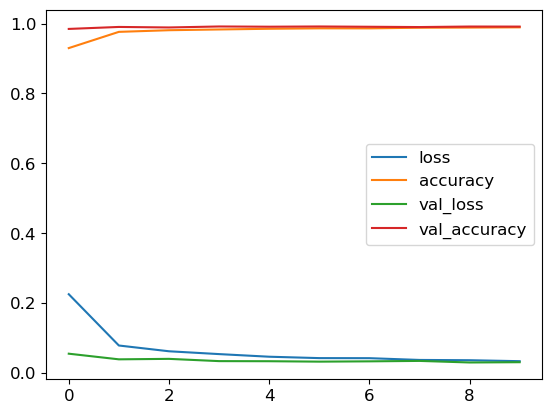

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

313/313 [==============================] - 0s 881us/step
fails total: 77 (10000)
title: expected / predicted
first 77 ...


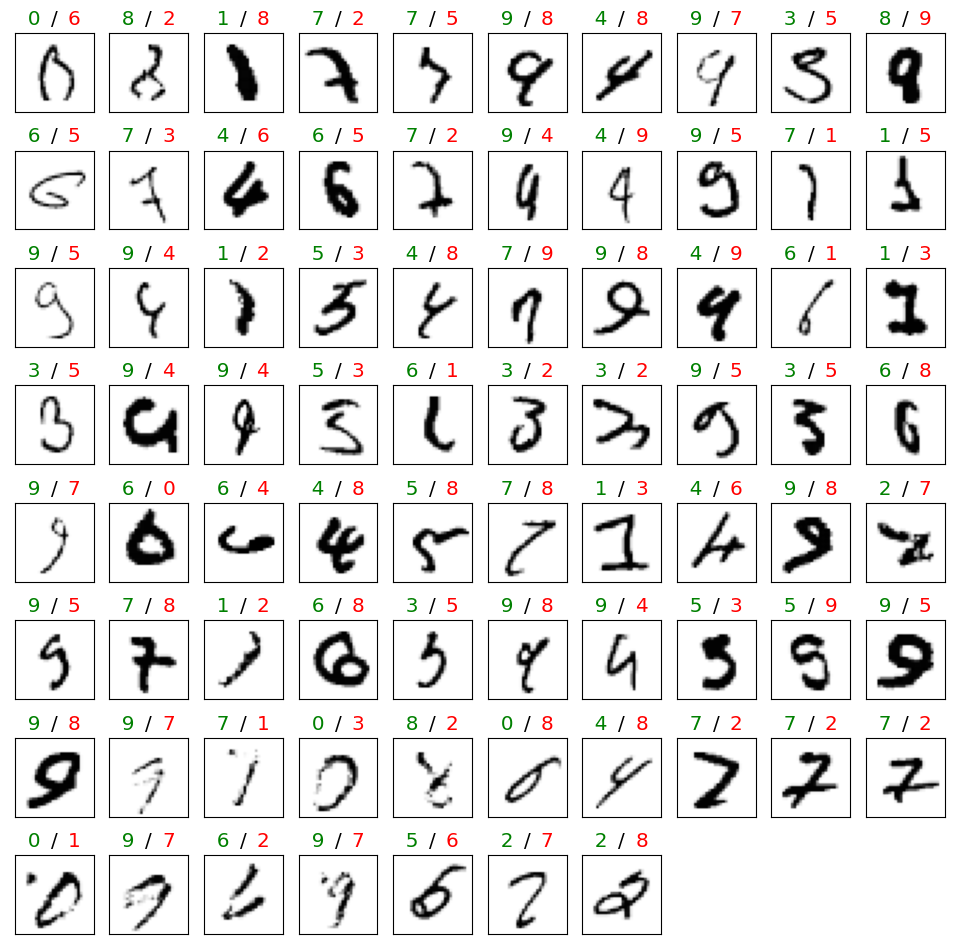

<IPython.core.display.Javascript object>

In [ ]:
#@title gpu test { form-width: "300px" }
#@markdown * the **tensorflow** [mnist example]( https://keras.io/examples/vision/mnist_convnet/)

from   matplotlib         import  pyplot as plt
from   google.colab       import  widgets
from   google.colab       import  output
from   tensorflow         import  keras
from   tensorflow.keras   import  layers
import                            numpy as np, matplotlib,\
                                  ipywidgets, tensorflow as tf
# free memory
tf.keras.backend.clear_session()

# cell-output design
tabs      = widgets.TabBar(['overview','model','training','scores','fails'])
columns   = 10
rows      = 10

# inits / forms
num_classes   = 10
input_shape   = (28, 28, 1)
batch_size    = 101 #@param {type: "slider", min: 1, max: 200}
epochs        = 10  #@param {type: "slider", min: 1, max: 20}
learning_rate = "0.0025" #@param ["0.9", "0.5", "0.2", "0.1", "0.01", "0.001", "0.0001"] {allow-input: true}
matplotlib.rc ('image', cmap='Greys')


# button function
button_plotoverview = ipywidgets.Button(description="plot overview")
def on_plotoverview_clicked(b):
  # disable button
  b.disabled = True

  # do the plot
  plot_overview ()

def plot_overview ():
  with tabs.output_to ('overview'):
    # figure dimension
    fig = plt.figure(figsize=(1.2*columns, 1.5*rows))

    # plot 
    for i in range(columns*rows):
      fig.add_subplot(rows, columns, i+1, xticks=[], yticks=[], title=f'{np.argmax(y_train[i])}')
      plt.imshow(x_train[i].reshape (28,28))


# overview-tab
with tabs.output_to ('overview'):
  # the data, split between train and test sets
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  # binding and display
  button_plotoverview.on_click(on_plotoverview_clicked)
  display(button_plotoverview)


# model-tab
with tabs.output_to ('model'):
  # generate model
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.5),
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  # print infos
  print("x_train shape:", x_train.shape)
  print("x_test shape: ", x_test.shape,"\n")
  model.summary()


# button function
button_starttraining = ipywidgets.Button(description="start training")
def on_starttraining_clicked(b):
  # disable button
  b.disabled = True

  # start training
  if tf.test.gpu_device_name() == '':  print('\t\x1b[31m Please activate gpu acceleration\x1b[0m')
  else: start_training()

# training-tab
with tabs.output_to ('training'):
  # binding and display
  button_starttraining.on_click(on_starttraining_clicked)
  display(button_starttraining)


def start_training ():
  # start training in training-tab
  with tabs.output_to ('training'):
    print(">accelerator",tf.test.gpu_device_name())
    print('>batch_size',batch_size)
    print('>epochs',epochs)
    print('>learning_rate',learning_rate)
    model.compile ( loss      = "categorical_crossentropy", 
                    optimizer = tf.keras.optimizers.Adam(learning_rate=float(learning_rate)),
                    metrics   = ["accuracy"])
   
    history = model.fit ( x_train, y_train,
                          batch_size        = batch_size, 
                          epochs            = epochs, 
                          validation_split  = 0.1)
    
  # draw scores-tab
  with tabs.output_to ('scores'):
    print('>please wait for evaluate loss and accuracy ...\n')
    for all in history.history: plt.plot(history.history[all])
    plt.legend(history.history.keys())    
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

  # draw fails-tab
  with tabs.output_to ('fails'):

    # looking for fails
    predictions, fails, total = model.predict (x_test), [], 0
    for i in range (len(predictions)):
      if (np.argmax (predictions[i]) != np.argmax (y_test[i])):
        fails.append ({'pos':       i,
                      'expected':  np.argmax (y_test[i]),
                      'predicted': np.argmax (predictions[i])} )
        total += 1

    # header
    failCount = min(columns*rows,len(fails))
    print (f'fails total: {total} ({len(predictions)})')
    print ('title: \x1b[92mexpected \x1b[30m/ \x1b[91mpredicted\x1b[30m')
    print (f'first {failCount} ...')
    
    # subplots
    fig = plt.figure(figsize=(1.2*columns, 1.5*rows))
    for i in range (failCount):
      fig.add_subplot (rows, columns, i+1, xticks=[], yticks=[])
      plt.title (f"  {fails[i]['expected']}",    color='green', loc='left')
      plt.title ("/",                          color='black', loc='center')
      plt.title (f"{fails[i]['predicted']}  ",   color='red',   loc='right')
      plt.imshow(x_test[fails[i]['pos']].reshape(28,28))



wait 30 - 60 seconds


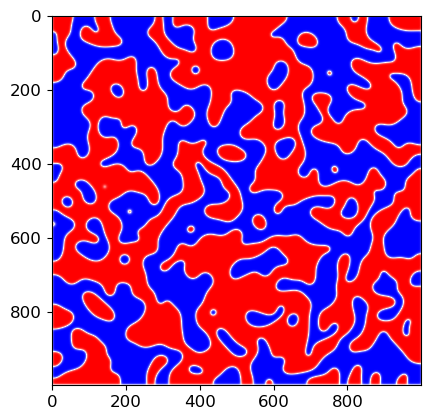

GPU Time: 0.9206316471099854


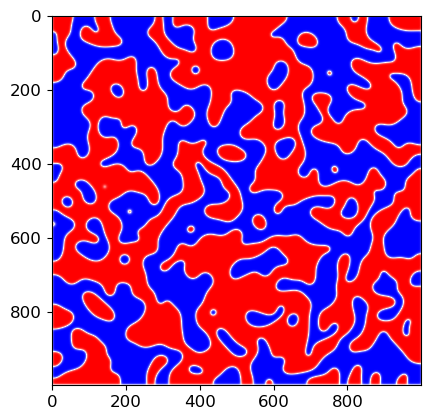

CPU Time: 26.725342750549316


In [ ]:
#@markdown **gpu test**
#@markdown * a **numba** example from [here]( https://github.com/Zhyrek/numba) shows a task that was solved once with cpu and once with gpu
from numba import cuda
from matplotlib import pyplot as plt
import time, numpy as np

# free memory
cuda.close()


def cahnallen_CPU_dirichlet(array, steps):
    phi = array.copy()
    M = 0.2
    dt = 1.
    dx = 1.
    idx2 = 1./(dx*dx)
    e = 1.
    e2 = e*e
    W = 0.2
    for i in range(steps):
        phi_xm = phi[0:-2,1:-1]
        phi_xp = phi[2:,1:-1]
        phi_ym = phi[1:-1,0:-2]
        phi_yp = phi[1:-1,2:]
        phi_center = phi[1:-1,1:-1]
        phi_center += M*dt*(e2*(phi_xm+phi_xp+phi_ym+phi_yp-4*phi_center)*idx2 - W*(4*phi_center**3 - 6*phi_center**2 + 2*phi_center))
    return phi
        
def cahnallen_GPU_dirichlet(array, steps):
    
    array_out = array.copy()
    
    array_gpu = cuda.to_device(array)
    array_out_gpu = cuda.to_device(array_out)
    
    @cuda.jit
    def cahnallen_kernel(c, c_out):
        startx, starty = cuda.grid(2)      
        stridex, stridey = cuda.gridsize(2) 
        M = 0.2
        dt = 1.
        dx = 1.
        idx2 = 1./(dx*dx)
        e = 1.
        e2 = e*e
        W = 0.2
        for i in range(starty+1, c.shape[0]-1, stridey):
            for j in range(startx+1, c.shape[1]-1, stridex):
                c_out[i][j] = c[i][j] + M*dt*((e2*(c[i+1][j]+c[i-1][j]+c[i][j+1]+c[i][j-1]-4*c[i][j]))*idx2 - W*(4*c[i][j]**3 - 6*c[i][j]**2 + 2*c[i][j])) 
            
    threads = (8,8)
    blocks = (8,8)
    
    for i in range(steps):
        cahnallen_kernel[threads, blocks](array_gpu, array_out_gpu)
        cuda.synchronize()
        array_gpu, array_out_gpu = array_out_gpu, array_gpu

    c = array_gpu.copy_to_host()
    return c

phi = 0.01*np.random.random([1000,1000])+0.495

print ('wait 30 - 60 seconds')

t0 = time.time()
gpu_result = cahnallen_GPU_dirichlet(phi, 1000)
t1 = time.time()
plt.imshow(gpu_result, cmap = "bwr")
plt.show()
print("GPU Time: "+str(t1-t0))

t0 = time.time()
cpu_result = cahnallen_CPU_dirichlet(phi, 1000)   
t1 = time.time()
plt.imshow(cpu_result, cmap = "bwr")
plt.show()
print("CPU Time: "+str(t1-t0))



/home/frank/mambaforge/envs/ml/lib/python3.10/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


epoch,train_loss,valid_loss,accuracy,time
0,0.564009,0.527769,0.989400,00:25


one image


predict: ('2', TensorBase(2), TensorBase([0.0141, 0.0072, 0.9124, 0.0101, 0.0071, 0.0094, 0.0124, 0.0072, 0.0117, 0.0086]))
train / valid


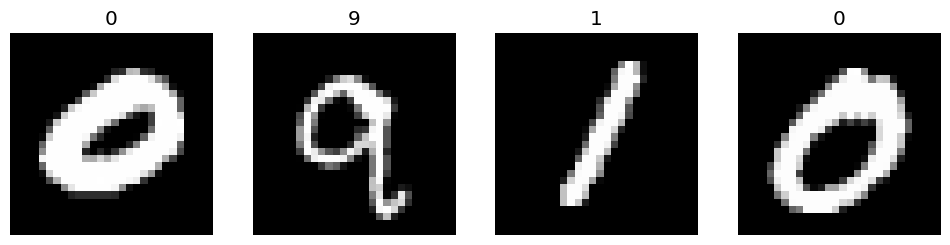

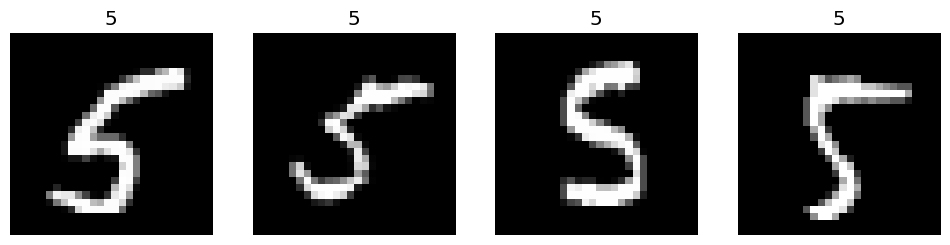

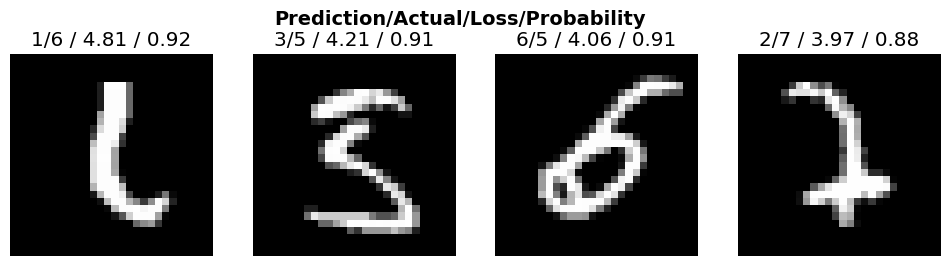

In [ ]:
#@markdown **gpu test**
#@markdown * mnist **pytorch** (fastai) example from [Deep-Learning-with-fastai-Cookbook](https://github.com/PacktPublishing/Deep-Learning-with-fastai-Cookbook)

try:
    import fastbook                     
except ImportError:
  !pip install -Uqq fastbook
  import fastbook
from fastbook import *
from fastai.vision.all import *
import warnings
warnings.filterwarnings('ignore')

# free memory
torch.cuda.empty_cache()

path = untar_data(URLs.MNIST)
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')

learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

learn.fit_one_cycle(1, 0.1)

print('one image')
img_files = get_image_files(path/"testing")
img = PILImage.create(img_files[7000])
display(img)
print ('predict:',learn.predict(img))

print ('train / valid')
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, nrows=1)



In [ ]:
#@title hosted runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM - '.format(ram_gb),end='')
if ram_gb < 20: print('Not using a high-RAM runtime')
else:           print('You are using a high-RAM runtime!')
print('')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0: print('Not connected to a GPU')
else:                            print(gpu_info)




# local runtime
1. install cuda 
2. install docker
3. install mamba
```
curl -L -O "https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-$(uname)-$(uname -m).sh"
bash Mambaforge-$(uname)-$(uname -m).sh
```
4. create a machine learning environment with colab, jupyter, tensorflow, pytorch, numba etc. - either directly or in a container
5. to use kaggle you have to copy the kaggle.json file in the ~/.kaggle folder (get it in your kaggle account settings).
```
cp ~/Downloads/kaggle.json ~/.kaggle; chmod 600 ~/.kaggle/kaggle.json
```

 


In [ ]:
#@title cuda

# nvidia-driver --> cudatoolkit --> cuDNN
"""
# https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html
# nvidia cuDNN: 
#      + nvidia-driver
#      |     +--> sudo add-apt-repository ppa:graphics-drivers/ppa -y
#      |     +--> apt list -a nvidia-driver* # --> 515 (highest number)
#      |     +--> sudo apt-get install nvidia-driver-515 # <-- 515
#      +--cuda-toolkit
#      |     +--> do this: https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html
#      |     +--> download: https://developer.nvidia.com/cuda-downloads
#      +--cuDNN: 
#      |     +->> do this: https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html#installlinux-deb
#            +--> change the values correct:  'x.x.x' from downloaded file, 'X.Y' from cuda version (nvidia-smi)
#
# to run mnistCUDNN:
sudo apt-get install libfreeimage3 libfreeimage-dev

# nvidia cuDNN (wsl2): 
#      + nvidia-driver
#      |     +--> sudo add-apt-repository ppa:graphics-drivers/ppa -y
#      |     +--> apt list -a nvidia-driver* # --> 515 (highest number)
#      |     +--> sudo apt-get install nvidia-driver-515 # <-- 515
#      +--cuda-toolkit
#      |     +--> do this: https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html
#      |     +--> download: https://developer.nvidia.com/cuda-downloads
#      +--cuDNN: 
#      |     +->> do this: https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html#installlinux-deb
#            +--> change the values correct:  'x.x.x' from downloaded file, 'X.Y' from cuda version (nvidia-smi)
#


windows
https://developer.nvidia.com/cuda-downloads?target_os=Linux&target_arch=x86_64&Distribution=WSL-Ubuntu&target_version=2.0&target_type=deb_local



"""
print ('nvidia-smi\n')
!nvidia-smi

In [ ]:
#@title docker

# docker --> nvidia-docker

# docker
"""
sudo apt-get install ca-certificates curl gnupg lsb-release
sudo apt-get remove docker docker-engine docker.io containerd runc    
sudo mkdir -p /etc/apt/keyrings
curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo gpg --dearmor -o /etc/apt/keyrings/docker.gpg    
echo \
  "deb [arch=$(dpkg --print-architecture) signed-by=/etc/apt/keyrings/docker.gpg] https://download.docker.com/linux/ubuntu \
  $(lsb_release -cs) stable" | sudo tee /etc/apt/sources.list.d/docker.list > /dev/null
sudo apt-get update
sudo apt-get install docker-ce docker-ce-cli containerd.io docker-compose-plugin
sudo service docker start  
sudo docker run hello-world
sudo apt install ./docker-desktop*.deb # from https://docs.docker.com/desktop/install/ubuntu/
sudo groupadd docker
sudo usermod -aG docker $USER
newgrp docker
gpg --generate-key
pass init 7865BA9185AFA2C26C5B505669FC4F36530097C2 !!! replace with yours (output gpg)
"""

# nvidia-docker 
"""
# from https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html
distribution=$(. /etc/os-release;echo $ID$VERSION_ID) \
      && curl -fsSL https://nvidia.github.io/libnvidia-container/gpgkey | sudo gpg --dearmor -o /usr/share/keyrings/nvidia-container-toolkit-keyring.gpg \
      && curl -s -L https://nvidia.github.io/libnvidia-container/$distribution/libnvidia-container.list | \
            sed 's#deb https://#deb [signed-by=/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg] https://#g' | \
            sudo tee /etc/apt/sources.list.d/nvidia-container-toolkit.list
sudo apt-get update
curl -s -L https://nvidia.github.io/nvidia-docker/gpgkey | \
  sudo apt-key add -sudo apt-get install -y nvidia-docker2
sudo systemctl restart docker
"""

# dashboard
"""
https://amytabb.com/ts/2020-09-19/#run-test
https://towardsdatascience.com/create-your-own-gpu-accelerated-yupyter-notebook-server-with-google-colab-using-docker-2fa14900bab5

docker run --gpus all -it --rm tensorflow/tensorflow:latest-gpu-jupyter bash
docker run --gpus all -p 8888:8888 -v /home/frank/labor/:/tf/labor/ -it --rm tensorflow/tensorflow:latest-gpu-jupyter bash
jupyter notebook --notebook-dir=/tf --ip 0.0.0.0 --no-browser --allow-root --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
jupyter notebook --notebook-dir="/tf/labor/content" --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 --no-browser --allow-root --NotebookApp.token='' --NotebookApp.disable_check_xsrf=True

"""

print ('nvidia-smi out of the container\n')
print ('>docker run --rm --gpus all nvidia/cuda:11.0.3-base-ubuntu20.04 nvidia-smi\n')
!docker run --rm --gpus all nvidia/cuda:11.0.3-base-ubuntu20.04 nvidia-smi

In [ ]:
#@title ml environment { form-width: "300px" }
#@markdown * tensorflow, pytorch, numba (with gpu)
#@markdown * jupyter, scikit, pandas, scrapy, colab and more


"""
# run once
mamba create --name ml python jupyter jupyter_http_over_ws pytorch torchvision matplotlib pandas pillow scrapy google-colab tqdm kaggle; mamba activate ml; pip install -Uqq fastbook; pip install tensorflow-gpu
jupyter serverextension enable --py jupyter_http_over_ws

# start jupyter notebook (copy the localhost-link)
jupyter notebook --notebook-dir="~/labor/content" --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 

# !!!ATTENTION!!! start jupyter notebook with access to local folder (no token)
# !!!ATTENTION!!! look here for more infos: https://stackoverflow.com/questions/54998936/unable-to-connect-to-the-local-runtime-in-google-colab
jupyter notebook --notebook-dir="~/labor/content" --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 --no-browser --allow-root --NotebookApp.token='' --NotebookApp.disable_check_xsrf=True
"""

import torch, numba, tensorflow as tf
from numba import cuda

print (f'pytorch    ({torch.__version__:15s}) get_device_name(0)  = {torch.cuda.get_device_name(0)}')
print (f"tensorflow ({tf.__version__:15s}) physical_devices[0] = {tf.config.list_physical_devices('GPU')[0]}")
print (f"numba      ({numba.__version__:15s}) select_device(0)    = {cuda.select_device(0)}")


pytorch    (1.12.1.post201 ) get_device_name(0)  = NVIDIA GeForce RTX 3060 Ti
tensorflow (2.10.0         ) physical_devices[0] = PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
numba      (0.56.3         ) select_device(0)    = <CUDA device 0 'b'NVIDIA GeForce RTX 3060 Ti''>


In [ ]:
#@title tensorboard
#@markdown start cell:<br>
#@markdown ```from tensorflow.keras.callbacks import TensorBoard```<br>
#@markdown ```log_folder = 'logs'```<br>
#@markdown ```%load_ext tensorboard```<br>
#@markdown end cell:<br>
#@markdown ```%tensorboard --logdir='logs' --host localhost --port 8088```<br>
from tensorflow.keras.callbacks import TensorBoard
log_folder = 'logs'
%load_ext tensorboard

import tensorflow as tf

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

model = tf.keras.models.Sequential([
   tf.keras.layers.Flatten(input_shape=(28, 28)),
   tf.keras.layers.Dense(512, activation='relu'),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='sgd', 
   loss='sparse_categorical_crossentropy',
   metrics=['accuracy'])

callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)]
model.fit(X_train, y_train,
          epochs=10,
          validation_split=0.2,
          callbacks=callbacks)  

%tensorboard --logdir='logs' --host localhost --port 8088
print ('for local runtime goto: http://localhost:8088/')

# video

In [ ]:
#@markdown **record video** { form-width: "300px" }
# Adapted from: https://stackoverflow.com/a/62804023/4879610
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename):
  js = Javascript("""
    async function recordVideo() {
      // mashes together the advanced_outputs.ipynb function provided by Colab, 
      // a bunch of stuff from Stack overflow, and some sample code from:
      // https://developer.mozilla.org/en-US/docs/Web/API/MediaStream_Recording_API

      // Optional frames per second argument.
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
      // create a media recorder instance, which is an object
      // that will let you record what you stream.
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      // Video is a media element.  This line here sets the object which serves
      // as the source of the media associated with the HTMLMediaElement
      // Here, we'll set it equal to the stream.
      video.srcObject = stream;

      // from https://stackoverflow.com/questions/62529304/is-there-any-way-to-capture-live-video-using-webcam-in-google-colab#comment114644726_62804023
      video.muted = true;

      // We're inside an async function, so this await will fire off the playing
      // of a video. It returns a Promise which is resolved when playback has 
      // been successfully started. Since this is async, the function will be 
      // paused until this has started playing. 
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // and now, just wait for the capture button to get clicked in order to
      // start recording
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      // use a promise to tell it to stop recording
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);

    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))


from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 300):
  # show saved video in colab.
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")



video_path = "test.mp4"
record_video(video_path)



show_video(video_path)

In [ ]:
#@markdown stream video
#https://www.quora.com/How-do-I-open-a-webcam-live-video-stream-in-Google-Colab

from IPython.display import HTML, Audio 
from google.colab.output import eval_js 
from base64 import b64decode 
import numpy as np 
import io 
from PIL import Image 
 
VIDEO_HTML = """ 
<video autoplay 
 width=%d height=%d style='cursor: pointer;'></video> 
<script> 
 
var video = document.querySelector('video') 
 
navigator.mediaDevices.getUserMedia({ video: true }) 
  .then(stream=> video.srcObject = stream) 
   
var data = new Promise(resolve=>{ 
  video.onclick = ()=>{ 
    var canvas = document.createElement('canvas') 
    var [w,h] = [video.offsetWidth, video.offsetHeight] 
    canvas.width = w 
    canvas.height = h 
    canvas.getContext('2d') 
          .drawImage(video, 0, 0, w, h) 
    video.srcObject.getVideoTracks()[0].stop() 
    video.replaceWith(canvas) 
    resolve(canvas.toDataURL('image/jpeg', %f)) 
  } 
}) 
</script> 
""" 
def take_photo(filename='photo.jpg', quality=0.8, size=(400,300)): 
  display(HTML(VIDEO_HTML % (size[0],size[1],quality))) 
  data = eval_js("data") 
  binary = b64decode(data.split(',')[1]) 
  f = io.BytesIO(binary) 
  return np.asarray(Image.open(f)) 
 
print ('click to take a photo...') 
img = take_photo() # click 
 
 
import matplotlib.pyplot as plt 
 
plt.figure(figsize=(5,5)) 
plt.imshow(img) 
plt.show() 

# widgets

In [ ]:
#@title youtube jukebox { form-width: "200px" }
from IPython.display import YouTubeVideo

jukebox = {"The Dead South - In Hell I'll Be In Good Company"   :"B9FzVhw8_bY",
           "Big Bad Voodoo Daddy - Why Me?"                     :"a3Z4RWZa9WA",
           "Kishi Bashi - Violin Tsunami"                       :"xlXwpaAVoJQ",
           "Jamie T - Sheila"                                   :"4-L7Cadb-c0",
           "Tash Sultana - Jungle"                              :"1ExkpBpYEPw"}

select = "The Dead South - In Hell I'll Be In Good Company" #@param ["The Dead South - In Hell I'll Be In Good Company","Big Bad Voodoo Daddy - Why Me?","Kishi Bashi - Violin Tsunami","Jamie T - Sheila","Tash Sultana - Jungle"]

display ( YouTubeVideo ( jukebox [ select ] ) )


In [ ]:
#@title radio buttons
import ipywidgets as widgets
import numpy


output_radio_selected = widgets.Text()
radio1 = widgets.RadioButtons(options=['mse'])
radio2 = widgets.RadioButtons(options=['mae'])

radio1.index = None
radio2.index = None

def radio1_observer(sender):
    #print(sender)
    radio2.unobserve(radio2_observer, names=['value'])
    radio2.index = None

    global selected_option
    output_radio_selected.value = radio1.value
    selected_option = output_radio_selected.value
    print('Selected option set to: ' + selected_option)

    radio2.observe(radio2_observer, names=['value'])

def radio2_observer(sender):
    radio1.unobserve(radio1_observer, names=['value'])
    radio1.index = None

    global selected_option2
    output_radio_selected.value = radio2.value
    selected_option2 = output_radio_selected.value
    print('Selected option set to: ' + selected_option2)

    radio1.observe(radio1_observer, names=['value'])


radio1.observe(radio1_observer, names=['value'])
radio2.observe(radio2_observer, names=['value'])

widgets.HBox([radio1,radio2])

# tex it 

$$\large \sum {\frac {Frit^z} {\sqrt[the] {C\alpha t}} }$$

# greek letters

<table>
<tr><td>Alpha $\alpha$ / $A$</td><td>Beta $\beta$ / $B$</td><td>Gamma $\gamma$ / $\Gamma$</td><td>Delta $\delta$ / $\Delta$</td><td>Epsilon $\epsilon$ / $E$</td><td>Zeta $\zeta$ / $Z$</td></tr>

<tr><td>Eta $\eta$ / $E$</td><td>Theta $\theta$ / $\Theta$</td><td>Iota $\iota$ / $I$</td><td>Kappa $\kappa$ / $K$</td><td>Lambda $\lambda$ / $\Lambda$</td><td>My $\mu$ / $M$</td></tr>

<tr><td>Ny $\nu$ / $N$</td><td>Xi $\xi$ / $\Xi$</td><td>Omikron $\omicron$ / $O$</td><td>Pi $\pi$ / $\Pi$</td><td>Rho $\rho$ / $R$</td><td>Sigma $\sigma$ / $\Sigma$</td></tr>

<tr><td>Tau $\tau$ / $T$</td><td>Ypsilon $\upsilon$ / $\Upsilon$</td><td>Phi $\phi$ / $\Phi$</td><td>Chi $\chi$ / $X$</td><td>Psi $\psi$ / $\Psi$</td><td>Omega $\omega$ / $\Omega$</td></tr>
</table>



# ```%linemagic``` and ```%%cellmagic```

* [Jupyter's magics page](http://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb) - from the [ipython project](https://github.com/ipython/ipython)


In [ ]:
#@markdown **list magics**
%lsmagic

In [ ]:
#@markdown **bash script**
%%bash

echo ls
ls
echo ''
echo 'pwd'
pwd
echo ''
echo '$PATH'
echo $PATH
echo ''
echo 'system'
cat /etc/os*

In [ ]:
#@markdown **html**
%%html

<table width="700"><tr><td width="200">
  <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 450 400" width="200" height="200">
    <rect x="80" y="60" width="250" height="250" rx="20" style="fill:red; stroke:black; fill-opacity:0.7" />
    <rect x="180" y="110" width="250" height="250" rx="40" style="fill:blue; stroke:black; fill-opacity:0.5;" />
  </svg>
</td><td>
  <marquee style='width: 30%; color: blue;'><b>Whee!</b></marquee>
</td></tr></table>





# gdrive hosting - does not longer work :-(

1. Connect your google account. This allows you to save directly to your gdrive from within applications. 
2. Create new inkscape file (as an example) and save it to you gdrive. (It doesn't work with linux - you have to download, edit, upload) 
3. Open your gdrive in the browser, right click to the saved file and choose 'release'.
4. In the popup under 'general access' choose the option 'anyone who has the link'.
5. Copy the link. You will get the wrong format. It looks like <br>
```https://drive.google.com/file/d/1cehK_fxj8vtBX1df3aKWF6RSOygzIAiR/view?usp=sharing```
6. Change it to the following format: <br> ```https://drive.google.com/uc?id=1cehK_fxj8vtBX1df3aKWF6RSOygzIAiR```
7. After reload the notebook in the browser the changes are visible.

<br>You can use the link in a ```<img>``` tag<br>
<img src='https://drive.google.com/uc?id=1cehK_fxj8vtBX1df3aKWF6RSOygzIAiR' width="400">

or you can use it in your code.
```python
from IPython.display import SVG
SVG('https://drive.google.com/uc?id=1cehK_fxj8vtBX1df3aKWF6RSOygzIAiR')
```


# inline images

1. Insert the html tag in your text cell. It look like this:
``` html
<div><img src="<data>" alt="alternative text"/></div>
```

2. Go to an [encoder page](https://www.base64-image.de/) (there are a lot) and generate the data string for your svg / jpg / etc ('copy image' button). 
3. Replace ```<data>``` with the string inside the quotes. The string have to beginn with <br>```data:image/svg+xml;base64,```
<div></div>

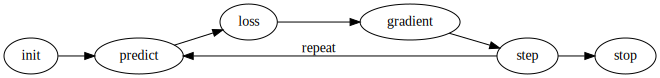

In [1]:
#@markdown svg with graphviz
import graphviz
s='init->predict->loss->gradient->step->stop\nstep->predict[label=repeat]'
graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')


# tables and lines

---
<table>
<tr><td>r1d1</td><td>r1d2</td><td>r1d3</td></tr>
<tr><td>r2d1</td><td>r2d2</td><td>r2d3</td></tr>
<tr><td>r3d1</td><td>r3d2</td><td>r3d3</td></tr>
</table>

---
<table>
<tr><td colspan=3>r1d1 colspan2</td></tr>
<tr><td>r2d1</td><td>r2d2</td><td>r2d3</td></tr>
<tr><td>r3d1</td><td>r3d2</td><td>r3d3</td></tr>
</table>

---
<table>
<tr><td>r1d1</td><td rowspan=3>r1d2<br>rowspan3</td><td>r1d3</td></tr>
<tr><td>r2d1</td><td>r2d2</td></tr>
<tr><td>r3d1</td><td>r3d2</td></tr>
</table>

---
<table>
<tr><td>r1d1</td><td>r1d2</td><td>r1d3</td><td>r1d4</td></tr>
<tr><td>r2d1</td><td colspan=2 rowspan=2>r2d2<br>colspan2<br>rowspan2</td><td>r2d3</td></tr>
<tr><td>r3d1</td><td>r3d2</td></tr>
<tr><td>r4d1</td><td>r4d2</td><td>r4d3</td><td>r4d4</td></tr>
</table>

---
<table>
<tr><td>r1d1</td><td>r1d2</td><td>r1d3</td><td>r1d4</td></tr>
<tr><td>r2d1</td><td colspan=2 rowspan=2 align=center>
$$\rule{7cm}{0.4pt}$$
$\left.{\;\\\;\\\;\\\;\\}\right\vert$
r2d2 - colspan2 - rowspan2$\left.{\;\\\;\\\;\\\;\\}\right\vert$<br>
$$\rule{7cm}{0.4pt}$$
</td><td>r2d3</td></tr>
<tr><td>r3d1</td><td>r3d2</td></tr>
<tr><td>r4d1</td><td>r4d2</td><td>r4d3</td><td>r4d4</td></tr>
</table>

---
<table><tr><td>

$\left.{\;}\right\vert$</td><td>

$\left.{\;\\}\right\vert$</td><td>

$\left.{\;\\\;\\}\right\vert$</td><td>

$\left.{\;\\\;\\\;\\}\right\vert$</td><td>

$\left.{\;\\\;\\\;\\\;\\\;\\}\right\vert$</td><td>

$\left.{\;\\\;\\\;\\\;\\\;\\\;\\}\right\vert$</td><td>

$\left.{\;\\\;\\\;\\\;\\\;\\\;\\\;\\}\right\vert$</td><td>

$\left.{\;\\\;\\\;\\\;\\\;\\\;\\\;\\\;\\}\right\vert$</td><td align=center>

$\rule{8cm}{0.4pt}$<br>
$\rule{10cm}{1pt}$<br>
$\rule{12cm}{4pt}$<br>
$\rule{10cm}{1pt}$<br>
$\rule{8cm}{0.4pt}$<br>

</td></tr></table>
